In [1]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.models import load_model


create_gif = False

# model reconstruction from JSON:
from keras.models import model_from_json

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")


import src.my_functions_product1 as myFC
import matplotlib.pyplot as plt

Using TensorFlow backend.


sklearn: 0.19.1
pandas: 0.23.0
kerads: 2.1.6


## Demo number: one_ user inputs only data, default models are used. 


In [2]:
demo = 'one_'

## Inputting from the user

In [3]:
# reading the file from a path and list the field names and input columns of interest

input_option = 'not manual' #'manual' or 'not manual'

#--------------------------------------
if True:
    
    path = 'Data/adult/'
    data_filename = 'adult.data'
    cprediction_field_exists = 'N'
    cprediction_field = ['N']
    target_field = ' <=50K'
    target_label0 = ' <=50K'
    target_label1 = ' >50K'
    sensitive_field = ' Male'
    not_to_consider_fields = [' Male']
    sensitive_class0 = ' Male'
    sensitive_class1 = ' Female'
    good_outcome = 'Income >50K'

#--------------------------------------
if False:

    path = 'Data/bank/'
    data_filename = 'bank.csv'
    cprediction_field_exists = 'N'
    cprediction_field = ['N']
    target_field = 'y'
    target_label0 = 'no'
    target_label1 = 'yes'
    sensitive_field = 'age'
    not_to_consider_fields = ['age']
    sensitive_class0 = '25-60'
    sensitive_class1 = '<25 or >60'
    good_outcome = 'Subsribed a deposit'

#--------------------------------------


X_df, Ybin, Zbin, result_fname = myFC.read_process_data_output_bias(path+data_filename, input_option,cprediction_field_exists,cprediction_field,target_field, sensitive_field, not_to_consider_fields,sensitive_class0,sensitive_class1,target_label0,target_label1)   


Columns in your data are:
  ['39' ' State-gov' ' 77516' ' Bachelors' ' 13' ' Never-married'
 ' Adm-clerical' ' Not-in-family' ' White' ' Male' ' 2174' ' 0' ' 40'
 ' United-States' ' <=50K']
burasi1
 Male
 Male
burasi2
target field: <=50K
target field: <=50K Label 0-1  <=50K,  >50K
sensitive field: Male Class 0-1  Male,  Female
not to consider fields [' Male']
result file:  Data--adult--adult.data_CP_N_T__<=50K__<=50K__>50K_S__Male__Male__Female_
Target field: p_rule_for_Y1 35.80


## Feature Creation

In [4]:
test_train_ratio = 0.5
X_train, X_test, y_train, y_test, Z_train, Z_test = myFC.feature_creation(X_df, Ybin, Zbin,test_train_ratio=test_train_ratio)

## Trying out different classifiers to see how good our default is

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [6]:
names_all = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers_all = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Class_to_compare = [0,1,2]
for item in Class_to_compare:
    name = names_all[item]
    classifier = classifiers_all[item]
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print(name, score)

Nearest Neighbors 0.812776412776
Linear SVM 0.846744471744
RBF SVM 0.787469287469


## Setting up default architectures

In [7]:
n_features = X_train.shape[1]
which_model = 'LR' #'NN4' or 'LR'
main_task_arch_json_string, adv_task_arch_json_string = myFC.Default_main_task_adv_architecture(n_features,which_model)

## Model and compile only main task: check prediction results

In [8]:
# no weights provided by the user, we will save the file
h5_file_name = path + which_model+'_new_h5_file_trained_here.h5'
save_the_weights = True

result_fname = path + 'Trade-off-results/'

main_task_accuracy, p_rule_for_Y1, y_pred = myFC.pre_train_main_task(main_task_arch_json_string,X_train, y_train,X_test,y_test,Z_test,save_the_weights=save_the_weights,h5_file_name=h5_file_name)



Accuracy: 85.18


## Combining the main task arch with the adversarial arch

### Train using pre-trained weights of main model

In [9]:
tradeoff_lambda_v = [12] 
pre_load_flag = True

main_task_trained_weight_file = h5_file_name#'main_task_ori_trained_model.h5'

for tradeoff_lambda in tradeoff_lambda_v:
    print('tradeoff_lambda = ', tradeoff_lambda)

    Bacc, Bp,B_y_pred, Aacc, Ap,A_y_pred,tradeoff_lambda = myFC.run_it_for_one_lambda(tradeoff_lambda,main_task_arch_json_string,adv_task_arch_json_string,pre_load_flag,main_task_trained_weight_file,X_train, y_train,Z_train,X_test,y_test,Z_test)
    result_fname_y_pred_before_after,result_fname_acc_p_before_after = myFC.saving_performance_result(Bacc, Bp,B_y_pred, Aacc, Ap,A_y_pred,tradeoff_lambda,result_fname)





tradeoff_lambda =  12
Accuracy: 85.18
Accuracy: 83.32


# Reading the result files

### Accuracy & p-score trade-off curves

In [11]:
Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

for item in range(len(tradeoff_lambda_v)):
    
    tradeoff_lambda = tradeoff_lambda_v[item]
    result_fname_acc_p_before_after = result_fname +'Result_acc_p_BA_' + 'L'+ str(tradeoff_lambda)+'.txt'
    #result_fname_acc_p_before_after = './Trade-off-results/'+result_fname_acc_p_before_after
    Bacc_Bp_Aacc_Ap = np.loadtxt(result_fname_acc_p_before_after, delimiter=',')

    Bacc_Bp_Aacc_Ap_results[item, :] = Bacc_Bp_Aacc_Ap

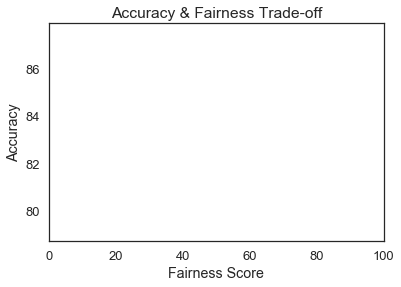

In [12]:

fname = path+'Figure-results/'+demo+which_model+'_'+'Trade'
plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('Fairness Score')
plt.ylabel('Accuracy')
plt.title('Accuracy & Fairness Trade-off')
plt.xlim(0,100)
#plt.ylim(0,100)
plt.savefig(fname, bbox_inches='tight')



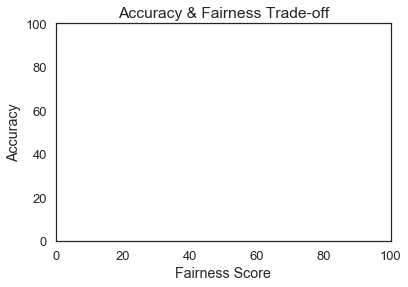

In [13]:
fname = path+'Figure-results/'+demo+which_model+'_'+'Trade-off-zoomout'
plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('Fairness Score')
plt.ylabel('Accuracy')
plt.title('Accuracy & Fairness Trade-off')
plt.xlim(0,100)
plt.ylim(0,100)
plt.savefig(fname, bbox_inches='tight')



#### Before & After Results

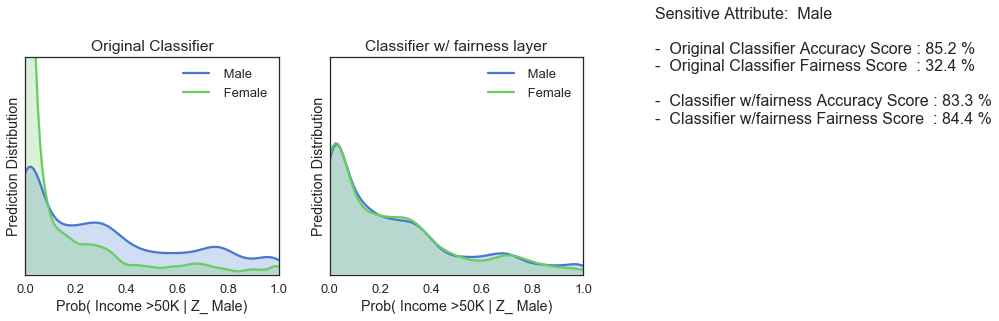

In [14]:
which_result = 0


fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'.png'

tradeoff_lambda = tradeoff_lambda_v[which_result]
result_fname_y_pred_before_after = result_fname + 'Result_y_pred_'+'L' + str(tradeoff_lambda) +'.txt'
BA_y_pred = np.loadtxt(result_fname_y_pred_before_after, delimiter=',')

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)


# without adversarial training
ax = sns.distplot(BA_y_pred[Z_test == 0,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class0),ax=axes[0])

ax = sns.distplot(BA_y_pred[Z_test == 1,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class1),ax=axes[0])
ax.set_xlim(0,1)
ax.set_ylim(0,5)
ax.set_yticks([])
ax.set_title("Original Classifier")#.format(sensitive_field))
ax.set_ylabel('Prediction Distribution')
ax.set_xlabel('Prob( {} | Z_{})'.format(good_outcome,sensitive_field))

# with adversarial training
ax = sns.distplot(BA_y_pred[Z_test == 0,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class0),ax=axes[1])

ax = sns.distplot(BA_y_pred[Z_test == 1,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class1),ax=axes[1])
ax.set_xlim(0,1)
ax.set_ylim(0,5)
ax.set_yticks([])
ax.set_title("Classifier w/ fairness layer")#.format(sensitive_field))
ax.set_ylabel('Prediction Distribution')
ax.set_xlabel('Prob( {} | Z_{})'.format(good_outcome,sensitive_field))


fig.text(1.0, 0.65, ''.join([f"Sensitive Attribute: {sensitive_field}\n\n",
                                       f"-  Original Classifier Accuracy Score : {100*Bacc_Bp_Aacc_Ap_results[which_result,0]:.1f} %\n",
                                       f"-  Original Classifier Fairness Score  : {Bacc_Bp_Aacc_Ap_results[which_result,1]:.1f} %\n\n",
                                       f"-  Classifier w/fairness Accuracy Score : {100*Bacc_Bp_Aacc_Ap_results[which_result,2]:.1f} %\n",
                                       f"-  Classifier w/fairness Fairness Score  : {Bacc_Bp_Aacc_Ap_results[which_result,3]:.1f} %"]),
                 fontsize='16')

plt.savefig(fname, bbox_inches='tight')

## FNR FPR

In [15]:
#result_fname = path + 'Trade-off-results/'+'FNR_FPR.txt'

Z_test = np.array(Z_test)
y_test = np.array(y_test)

#let's focus on sensitive class 0
samples = Z_test==0
y_test_samples = np.array(y_test[samples])
y_pred = np.array(BA_y_pred[:,0])
y_pred_samples = y_pred[samples]
FNR, FPR = myFC.FNR_FPR(y_pred_samples,y_test_samples)
print('Sensitive Class 0 w/o fairness FNR= {}, FPR= {}\n'.format(FNR,FPR))

#let's focus on sensitive class 0
samples = Z_test==0
y_test_samples = np.array(y_test[samples])
y_pred = np.array(BA_y_pred[:,1])
y_pred_samples = y_pred[samples]
FNR, FPR = myFC.FNR_FPR(y_pred_samples,y_test_samples)
print('Sensitive Class 0 w/ fairness FNR= {}, FPR= {}\n'.format(FNR,FPR))

print('-'*80+'\n')
#let's focus on sensitive class 1
samples = Z_test==1
y_test_samples = np.array(y_test[samples])
y_pred = np.array(BA_y_pred[:,0])
y_pred_samples = y_pred[samples]
FNR, FPR = myFC.FNR_FPR(y_pred_samples,y_test_samples)
print('Sensitive Class 1 w/o fairness FNR= {}, FPR= {}\n'.format(FNR,FPR))

#let's focus on sensitive class 1
samples = Z_test==1
y_test_samples = np.array(y_test[samples])
y_pred = np.array(BA_y_pred[:,1])
y_pred_samples = y_pred[samples]
FNR, FPR = myFC.FNR_FPR(y_pred_samples,y_test_samples)
print('Sensitive Class 1 w/ fairness FNR= {}, FPR= {}\n'.format(FNR,FPR))



Sensitive Class 0 w/o fairness FNR= 0.37813349441256416, FPR= 0.10219751125231666

Sensitive Class 0 w/ fairness FNR= 0.5385080036242827, FPR= 0.05361397934868944

--------------------------------------------------------------------------------

Sensitive Class 1 w/o fairness FNR= 0.44426229508196724, FPR= 0.024557752341311134

Sensitive Class 1 w/ fairness FNR= 0.26557377049180325, FPR= 0.07596253902185224



## Let's plot how individuals move around 
### subsample the samples


In [16]:
#subsample the samples
samples = np.random.randint(y_pred.shape[0], size=1000)

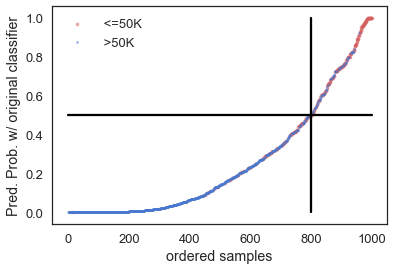

In [22]:
#predictions from the original classifier
y_pred = np.array(BA_y_pred[:,0])
sy_pred = y_pred[samples]
sy_test = y_test[samples]
sZ_test = Z_test[samples]

#samples ordered according to their prediction values
order_y_pred = sy_pred.argsort()

#Let's order other vectors as well.
Z_test_o = sZ_test[order_y_pred]
y_test_o = sy_test[order_y_pred]
y_pred_o = sy_pred[order_y_pred]
vec = np.arange(sy_pred.shape[0])

ones = y_pred_o>0.5
border_one = np.where(y_pred_o>0.5)
border_one = border_one[0][0]



tar0_rows = (y_test_o == 0)
tar1_rows = (y_test_o == 1)

plt.figure(1)
plt.scatter(vec[tar1_rows], y_pred_o[tar1_rows], s=10,c="r", alpha=0.5,marker='o',label=target_label0)
plt.scatter(vec[tar0_rows], y_pred_o[tar0_rows], s=5,c="b", alpha=0.5,label=target_label1)
plt.plot(vec,0.5*np.ones_like(vec),c='black')
plt.plot(border_one*np.ones_like(np.array([0,1])),np.array([0,1]),c='black')
plt.xlabel("ordered samples")
plt.ylabel("Pred. Prob. w/ original classifier")
plt.legend(loc=2)
#plt.title('Predictions with original classifier')

fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'points1_'+'.png'
plt.savefig(fname, bbox_inches='tight')

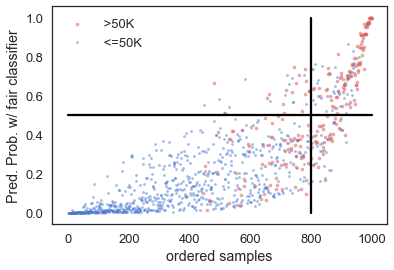

In [23]:
#predictions from the original classifier
y_pred = np.array(BA_y_pred[:,1])
sy_pred = y_pred[samples]
sy_test = y_test[samples]
sZ_test = Z_test[samples]

#samples ordered according to their prediction values
#order_y_pred = sy_pred.argsort()

#Let's order other vectors as well.
Z_test_o = sZ_test[order_y_pred]
y_test_o = sy_test[order_y_pred]
y_pred_o = sy_pred[order_y_pred]
vec = np.arange(sy_pred.shape[0])


tar0_rows = (y_test_o == 0)
tar1_rows = (y_test_o == 1)

plt.figure(1)
plt.scatter(vec[tar1_rows], y_pred_o[tar1_rows], s=10,c="r", alpha=0.5,marker='o',label=target_label1)
plt.scatter(vec[tar0_rows], y_pred_o[tar0_rows], s=5,c="b", alpha=0.5,label=target_label0)
plt.plot(vec,0.5*np.ones_like(vec),c='black')
plt.plot(border_one*np.ones_like(np.array([0,1])),np.array([0,1]),c='black')
plt.xlabel("ordered samples")
plt.ylabel("Pred. Prob. w/ fair classifier")
plt.legend(loc=2)
#plt.title('Predictions with fair classifier')
fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'points2_'+'.png'
plt.savefig(fname, bbox_inches='tight')

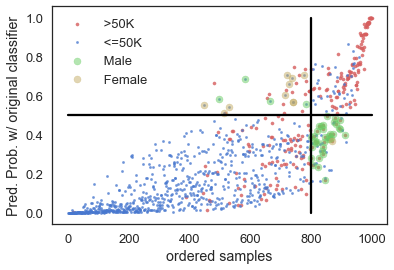

In [24]:
#predictions from the original classifier
y_pred = np.array(BA_y_pred[:,1])
sy_pred = y_pred[samples]
sy_test = y_test[samples]
sZ_test = Z_test[samples]

#samples ordered according to their prediction values
#order_y_pred = sy_pred.argsort()

#Let's order other vectors as well.
Z_test_o = sZ_test[order_y_pred]
y_test_o = sy_test[order_y_pred]
y_pred_o = sy_pred[order_y_pred]
vec = np.arange(sy_pred.shape[0])


tar0_rows = (y_test_o == 0)
tar1_rows = (y_test_o == 1)

#lower boundary
tar0_y_pred1_rows_Z0 = (y_test_o[:border_one] == 0)&(y_pred_o[:border_one] > 0.5)& (Z_test_o[:border_one]==0)
tar0_y_pred1_rows_Z1 = (y_test_o[:border_one] == 0)&(y_pred_o[:border_one] > 0.5)& (Z_test_o[:border_one]==1)

#upper boundary
tar1_y_pred0_rows_Z0u = (y_test_o[border_one:] == 1)&(y_pred_o[border_one:] < 0.5)& (Z_test_o[border_one:]==0)
tar1_y_pred0_rows_Z1u = (y_test_o[border_one:] == 1)&(y_pred_o[border_one:] < 0.5)& (Z_test_o[border_one:]==1)

plt.figure(1)
plt.scatter(vec[tar1_rows], y_pred_o[tar1_rows], s=10,c="r", alpha=0.8,marker='o',label=target_label1)
plt.scatter(vec[tar0_rows], y_pred_o[tar0_rows], s=5,c="b", alpha=0.8,label=target_label0)

plt.scatter(vec[:border_one][tar0_y_pred1_rows_Z0], y_pred_o[:border_one][tar0_y_pred1_rows_Z0], s=50,c="g", alpha=0.5,marker='o',label=sensitive_class0)
plt.scatter(vec[:border_one][tar0_y_pred1_rows_Z1], y_pred_o[:border_one][tar0_y_pred1_rows_Z1], s=50,c="y", alpha=0.5,marker='o',label=sensitive_class1)

plt.scatter(vec[border_one:][tar1_y_pred0_rows_Z0u], y_pred_o[border_one:][tar1_y_pred0_rows_Z0u], s=50,c="g", alpha=0.5,marker='o')
plt.scatter(vec[border_one:][tar1_y_pred0_rows_Z1u], y_pred_o[border_one:][tar1_y_pred0_rows_Z1u], s=50,c="y", alpha=0.5,marker='o')



plt.plot(vec,0.5*np.ones_like(vec),c='black')
plt.plot(border_one*np.ones_like(np.array([0,1])),np.array([0,1]),c='black')
plt.xlabel("ordered samples")
plt.ylabel("Pred. Prob. w/ original classifier")
plt.legend(loc=2)
#plt.title('Predictions with fair classifier')
fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'points3_'+'.png'
plt.savefig(fname, bbox_inches='tight')

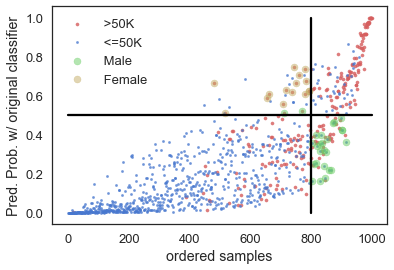

In [28]:
#predictions from the original classifier
y_pred = np.array(BA_y_pred[:,1])
sy_pred = y_pred[samples]
sy_test = y_test[samples]
sZ_test = Z_test[samples]

#samples ordered according to their prediction values
#order_y_pred = sy_pred.argsort()

#Let's order other vectors as well.
Z_test_o = sZ_test[order_y_pred]
y_test_o = sy_test[order_y_pred]
y_pred_o = sy_pred[order_y_pred]
vec = np.arange(sy_pred.shape[0])


tar0_rows = (y_test_o == 0)
tar1_rows = (y_test_o == 1)

#upper boundary
tar0_y_pred0_rows_Z0u = (y_test_o[border_one:] == 0)&(y_pred_o[border_one:] <= 0.5)& (Z_test_o[border_one:]==0)
tar0_y_pred0_rows_Z1u = (y_test_o[border_one:] == 0)&(y_pred_o[border_one:] <= 0.5)& (Z_test_o[border_one:]==1)

#lower boundary
tar1_y_pred1_rows_Z0 = (y_test_o[:border_one] == 1)&(y_pred_o[:border_one] > 0.5)& (Z_test_o[:border_one]==0)
tar1_y_pred1_rows_Z1 = (y_test_o[:border_one] == 1)&(y_pred_o[:border_one] > 0.5)& (Z_test_o[:border_one]==1)

plt.figure(1)
plt.scatter(vec[tar1_rows], y_pred_o[tar1_rows], s=10,c="r", alpha=0.8,marker='o',label=target_label1)
plt.scatter(vec[tar0_rows], y_pred_o[tar0_rows], s=5,c="b", alpha=0.8,label=target_label0)

plt.scatter(vec[border_one:][tar0_y_pred0_rows_Z0u], y_pred_o[border_one:][tar0_y_pred0_rows_Z0u], s=50,c="g", alpha=0.5,marker='o',label=sensitive_class0)
plt.scatter(vec[border_one:][tar0_y_pred0_rows_Z1u], y_pred_o[border_one:][tar0_y_pred0_rows_Z1u], s=50,c="y", alpha=0.5,marker='o',label=sensitive_class1)

plt.scatter(vec[:border_one][tar1_y_pred1_rows_Z0], y_pred_o[:border_one][tar1_y_pred1_rows_Z0], s=50,c="g", alpha=0.5,marker='o')
plt.scatter(vec[:border_one][tar1_y_pred1_rows_Z1], y_pred_o[:border_one][tar1_y_pred1_rows_Z1], s=50,c="y", alpha=0.5,marker='o')



plt.plot(vec,0.5*np.ones_like(vec),c='black')
plt.plot(border_one*np.ones_like(np.array([0,1])),np.array([0,1]),c='black')
plt.xlabel("ordered samples")
plt.ylabel("Pred. Prob. w/ original classifier")
plt.legend(loc=2)
#plt.title('Predictions with fair classifier')
fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'points4_'+'.png'
plt.savefig(fname, bbox_inches='tight')